## Часть 2 - анализ текстовых данных

Провести аналитику текстовых данных.

1. Токенезировать и лемматизировать полученные текстовые данные полученные из 1 части задания

- Токенизация - разделение слов на предложения
- Лемматизация - перевод слов в начальную форму

2. Посчитать наиболее встречающиеся пары подлежащих и сказуемых
3. Посчитать самые популлярные слова (исключая стоп-слова, словарь стоп слов можно найти в nltk, либо отбросить по частям речи)
4. Вывести статистику (по убыванию, наиболее встречающеся пары и самые популярные слова за исключением стоп-слов)

In [2]:
# Импорты
!pip install natasha
!pip install nltk
import sqlite3
import natasha
import nltk
from nltk.corpus import stopwords
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import DataFrame
nltk.download('stopwords')


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lunar\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
conn = sqlite3.connect('articles.db')
CURSOS = conn.cursor()
CURSOS.execute('''SELECT title FROM articles LIMIT 20''')
titles = CURSOS.fetchall()
CURSOS.execute('''SELECT body FROM articles LIMIT 20''')
texts = CURSOS.fetchall()

In [4]:
data = dict(zip(titles, texts)) # p.s. здесь вы открываете полученные данные

# Для примера можно использовать natasha
# !pip install natasha
from natasha import (
    Segmenter,
    MorphVocab,

    NewsEmbedding,
    NewsMorphTagger,
    NewsSyntaxParser,
    NewsNERTagger,

    PER,
    NamesExtractor,

    Doc
)

segmenter = Segmenter()
morph_vocab = MorphVocab()

emb = NewsEmbedding()
morph_tagger = NewsMorphTagger(emb)
syntax_parser = NewsSyntaxParser(emb)
ner_tagger = NewsNERTagger(emb)

names_extractor = NamesExtractor(morph_vocab)

In [5]:
from ipymarkup import show_dep_ascii_markup as show_markup
articles = list(data.values())
article = articles[19]


doc = Doc(str(article))
doc.segment(segmenter)
doc.parse_syntax(syntax_parser)
doc.tag_morph(morph_tagger)

for sentence in doc.sents: # получаем предложения
  sentence.syntax.print()

┌──────────► (             punct
│         ┌► '             punct
│       ┌─└─ Фото          
│       │ ┌► :             punct
│   ┌─┌─└►└─ Inna          appos
│   │ │ └──► Varenytsia    flat:foreign
│   │ │   ┌► /             punct
│   │ └►┌─└─ Reuters       flat:foreign
│   │   └──► \             punct
│   └──────► n             appos
│       ┌►┌─ Во            case
│       │ └► время         fixed
│       │ ┌► ночной        amod
│ ┌►┌───└─└─ атаки         obl
│ │ │   │ ┌► Вооруженных   amod
│ │ │ ┌─└►└─ сил           nmod
│ │ │ │ └──► Украины       nmod
│ │ │ │   ┌► (             punct
│ │ │ └►┌─└─ ВСУ           parataxis
│ │ │   └──► )             punct
│ │ │   ┌──► на            case
│ │ │   │ ┌► Краснодарский amod
│ │ └──►└─└─ край          nmod
│ │       ┌► трансформатор nsubj
└─└───┌─┌─└─ получил       
      │ └──► повреждения   obj
      └────► .             punct
              ┌► Об              case
            ┌►└─ этом            obl
┌───────────└─┌─ сообщил         
│   

In [6]:
# Получение токенов
for sentence in doc.sents:
  for token in sentence.tokens:
    print(token)

# Заменяем слова на их леммы (начальные формы слова)
for sentence in doc.sents:
  for token in sentence.tokens:
    token.lemmatize(morph_vocab)
  lemmas = {_.text: _.lemma for _ in sentence.tokens}
  print(lemmas.items())

DocToken(stop=1, text='(', id='1_1', head_id='1_25', rel='punct', pos='PUNCT')
DocToken(start=1, stop=2, text="'", id='1_2', head_id='1_3', rel='punct', pos='PUNCT')
DocToken(start=2, stop=6, text='Фото', id='1_3', head_id='1_3', rel='parataxis', pos='NOUN', feats=<Inan,Nom,Neut,Sing>)
DocToken(start=6, stop=7, text=':', id='1_4', head_id='1_5', rel='punct', pos='PUNCT')
DocToken(start=8, stop=12, text='Inna', id='1_5', head_id='1_3', rel='appos', pos='X', feats=<Yes>)
DocToken(start=13, stop=23, text='Varenytsia', id='1_6', head_id='1_5', rel='flat:foreign', pos='X', feats=<Yes>)
DocToken(start=24, stop=25, text='/', id='1_7', head_id='1_8', rel='punct', pos='PUNCT')
DocToken(start=26, stop=33, text='Reuters', id='1_8', head_id='1_5', rel='flat:foreign', pos='X', feats=<Yes>)
DocToken(start=33, stop=34, text='\\', id='1_9', head_id='1_8', rel='punct', pos='PUNCT')
DocToken(start=34, stop=35, text='n', id='1_10', head_id='1_5', rel='appos', pos='X', feats=<Yes>)
DocToken(start=35, stop

In [7]:
# Записываем в словарь подлежащее : сказуемое
pairs = {}
for sentence in doc.sents:
    nsubj = root = ''
    for token in sentence.tokens:
        token.lemmatize(morph_vocab)
        if token.rel in {"nsubj", "root"}:
            if token.rel == "nsubj":
                nsubj = token.lemma
            elif token.rel == "root":
                root = token.lemma
            if nsubj and root:
                pairs[nsubj] = root

all_pairs = []
for article in articles:
  doc = Doc(str(article))
  doc.segment(segmenter)
  doc.parse_syntax(syntax_parser)
  doc.tag_morph(morph_tagger)
  for sentence in doc.sents:
    nsubj = root = ''
    for token in sentence.tokens:
      token.lemmatize(morph_vocab)
      if token.rel == "nsubj":
        nsubj = token.lemma
      if token.rel == 'root':
        root = token.lemma
      if nsubj and root:
        all_pairs.append((nsubj, root))

print(all_pairs)
all_pairs_count = Counter(all_pairs)
all_pairs_count.most_common(20)

[('группировка', 'освободить'), ('группировка', 'освободить'), ('группировка', 'освободить'), ('группировка', 'освободить'), ('группировка', 'освободить'), ('армия', 'нанести'), ('армия', 'нанести'), ('армия', 'нанести'), ('армия', 'нанести'), ('армия', 'нанести'), ('армия', 'нанести'), ('армия', 'нанести'), ('армия', 'нанести'), ('армия', 'нанести'), ('армия', 'нанести'), ('армия', 'нанести'), ('армия', 'нанести'), ('армия', 'нанести'), ('армия', 'поразить'), ('армия', 'поразить'), ('армия', 'поразить'), ('армия', 'поразить'), ('армия', 'поразить'), ('армия', 'поразить'), ('армия', 'поразить'), ('армия', 'поразить'), ('армия', 'поразить'), ('армия', 'поразить'), ('армия', 'поразить'), ('войско', 'нанести'), ('войско', 'нанести'), ('войско', 'нанести'), ('войско', 'нанести'), ('войско', 'нанести'), ('войско', 'нанести'), ('войско', 'нанести'), ('войско', 'нанести'), ('войско', 'нанести'), ('войско', 'нанести'), ('войско', 'нанести'), ('войско', 'нанести'), ('войско', 'нанести'), ('войс

[(('издание', 'сообщать'), 30),
 (('житель', 'стать'), 29),
 (('следователь', 'проделать'), 28),
 (('киев', 'терять'), 26),
 (('глава', 'добавить'), 25),
 (('президент', 'мочь'), 24),
 (('издание', 'передавать'), 23),
 (('устрица', 'предложить'), 23),
 (('путин', 'заявить'), 23),
 (('риа', 'сообщать'), 22),
 (('он', 'понравиться'), 22),
 (('он', 'изучить'), 22),
 (('президент', 'рассказать'), 21),
 (('мы', 'терять'), 21),
 (('компания', 'должный'), 21),
 (('депутат', 'заявить'), 21),
 (('съемка', 'рассказать'), 21),
 (('обвинять', 'оказать'), 20),
 (('автомобиль', 'войти'), 20),
 (('штраф', 'сообщать'), 20)]

In [8]:
# Наиболее частовстречающиеся слова, исключая стоп слова, знаки пунктуации и числа, а также англ. n (знак переноса строки)
import string
filtered = []
punctuation = set(string.punctuation + '«»—' + string.digits + 'n')
stop_words = set(stopwords.words('russian'))
for article in articles:
  doc = Doc(str(article))
  doc.segment(segmenter)
  doc.parse_syntax(syntax_parser)
  doc.tag_morph(morph_tagger)
  for sentence in doc.sents:
    for token in sentence.tokens:
      token.lemmatize(morph_vocab)
      if token.lemma not in punctuation and token.lemma not in stop_words:
        filtered.append(token.lemma)

filtered_count = Counter(filtered)
filtered_count.most_common(20)

[('это', 25),
 ('фото', 20),
 ('россия', 17),
 ('год', 16),
 ('российский', 15),
 ('который', 13),
 ('путин', 12),
 ('украина', 11),
 ('ранее', 11),
 ('тысяча', 11),
 ('президент', 10),
 ('заявить', 10),
 ('сообщить', 9),
 ('свой', 9),
 ('время', 9),
 ('слово', 9),
 ('всу', 8),
 ('риа', 8),
 ('новость', 8),
 ('глава', 8)]

Топ 3 наиболее часто встречающихся слова: 'это' 'фото' 'россия' 

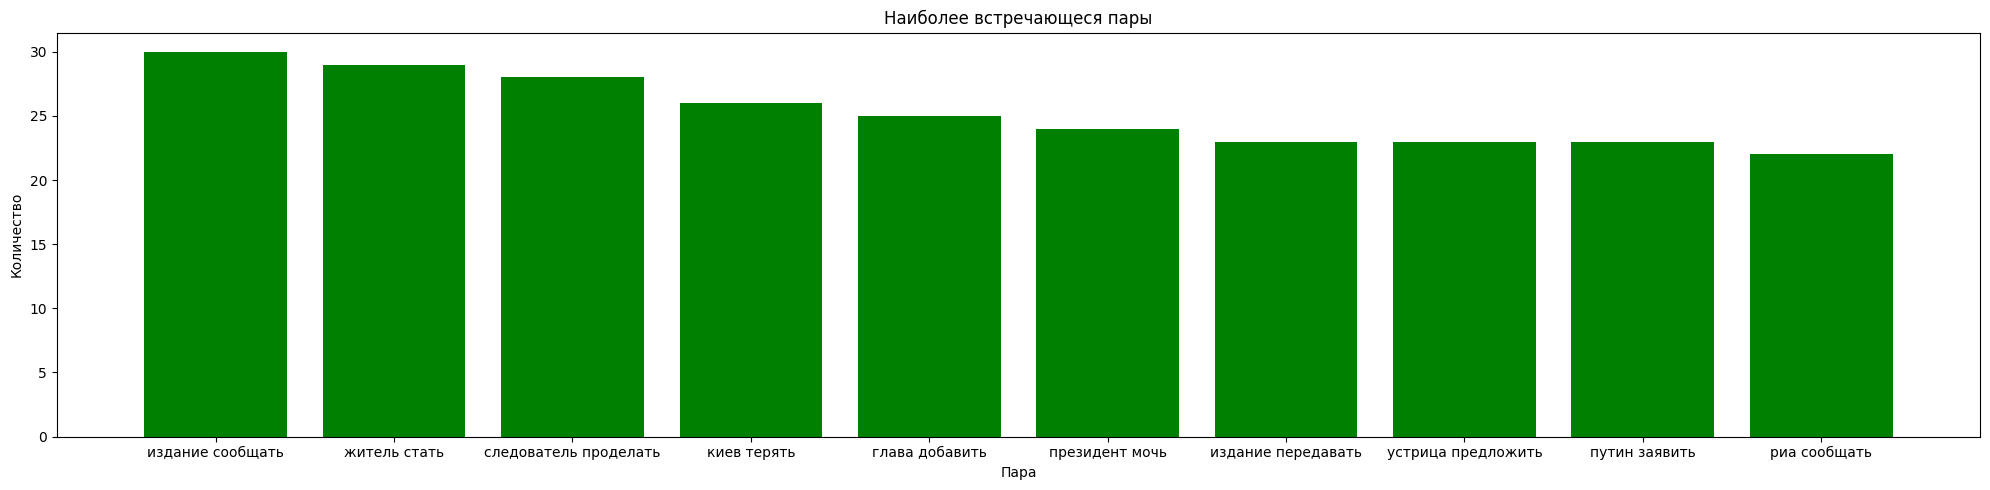

In [12]:
pairs = [pair[0][0] + ' ' + pair[0][1] for pair in all_pairs_count.most_common(10)]
count = [pair[1] for pair in all_pairs_count.most_common(10)]

plt.figure(figsize=(20, 5))
plt.bar(pairs, count, color = 'green')
plt.title("Наиболее встречающеся пары")
plt.ylabel("Количество")
plt.xlabel("Пара")
plt.tight_layout()
plt.show()


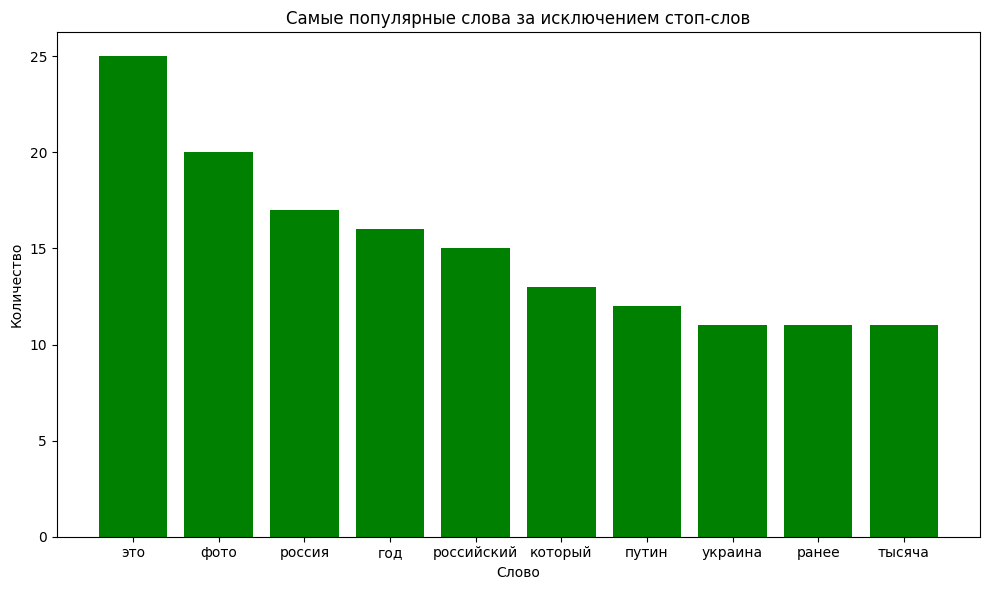

In [11]:
words = [pair[0] for pair in filtered_count.most_common(10)]
count = [pair[1] for pair in filtered_count.most_common(10)]

plt.figure(figsize=(10, 6))
plt.bar(words, count, color = 'green')
plt.title("Самые популярные слова за исключением стоп-слов")
plt.ylabel("Количество")
plt.xlabel("Слово")
plt.tight_layout()
plt.show()
